# Quick Start

This quick start tutorial will demonstrate the basic usage of dnamite. For more detailed usage see the user guides.

In [29]:
import numpy as np  
import pandas as pd
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Why Use dnamite?

Given a set of $p$ features $X$, dnamite trains additive models with the form $f(X) = \sum_j f_j (X_j)$. 
Such additive models maintain similar structure to linear models but allow each feature function (also known as *shape function*) $f_j$ to be nonlinear thus improving predictive accuracy.
By maintaining additive structure, a trained dnamite model can directly describe its predictions via shape functions, and can summarize the importance of each feature via feature importance scores. 
Therefore, dnamite is suitable when both accuracy and interpretability are important.
For more details see the [Why dnamite User Guide](https://dnamite.readthedocs.io/en/latest/notebooks/user_guides/why_dnamite.html).

## Regression

We'll start by importing some packages and reading in the California Housing dataset, a standard regression dataset. The task is to predict the median house value for a given district in California.
No data preprocessing is requires as dnamite can handle missing values and categorical features natively.

In [ ]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

To fit a dnamite model, we use `DNAMiteRegressor`. Binary classification is very similar but with `DNAMiteBinaryClassifier`. The only required input parameter is `n_features`, which should be set to the number of features in our training dataset. We pass two additional optional parameters: 1) `device`, which allows for GPU training if available, and 2) `num_pairs`, which asks the model to include a set number of pairwise interaction.

In [8]:
from dnamite.models import DNAMiteRegressor

model = DNAMiteRegressor(
    n_features=X_train.shape[1],
    device=device,
    num_pairs=5
)
model.fit(X_train, y_train)

Let's first check that our fitted model has reasonable predictive accuracy by comparing to a black-box ML model from scikit-learn.

In [9]:
preds = model.predict(X_test)
print(f"DNAMite RMSE: {np.sqrt(np.mean((preds - y_test)**2))}")

# Compare to an sklearn model
from sklearn.ensemble import HistGradientBoostingRegressor
gbr = HistGradientBoostingRegressor()
gbr.fit(X_train, y_train)
preds = gbr.predict(X_test)
print(f"HistGBR RMSE: {np.sqrt(np.mean((preds - y_test)**2))}")

DNAMite RMSE: 0.5050701082806425
HistGBR RMSE: 0.47592425762390833


We can now start interpreting our model. First we can look at the top feature importances from the model.

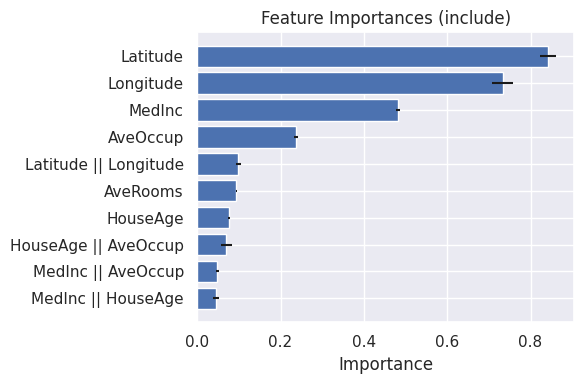

In [10]:
model.plot_feature_importances(n_features=10)

Latitude, longitude, and their interaction are all important terms in the model, which makes sense for predicting house prices in a state like California. The median income of the district is also an important predictor.

Now we can plot shape functions for some of the more important terms in the model. 
Since the trained model is additive, these plots directly describe how each feature contributes to the final prediction.

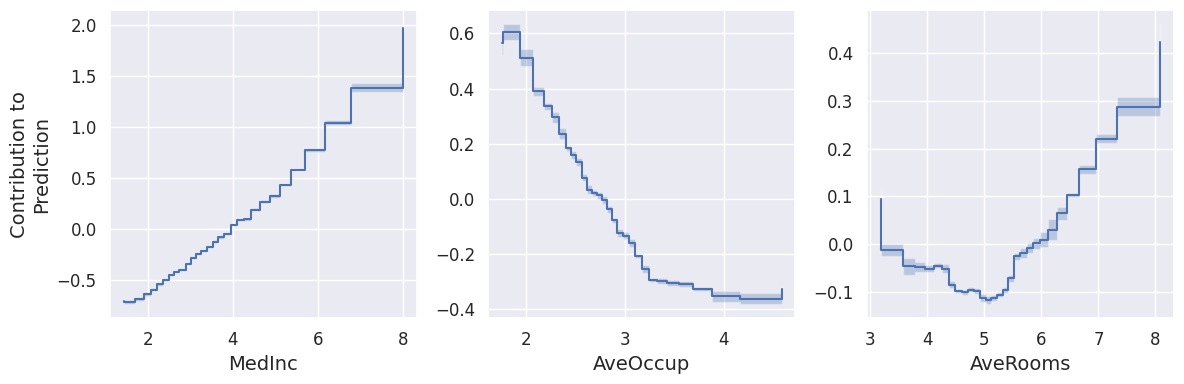

In [11]:
model.plot_shape_function(["MedInc", "AveOccup", "AveRooms"])

As expected, median income and average number of rooms are positively correlated with house price. Meanwhile, it's perhaps less expected that average number of occupants is negatively correlated with house price.

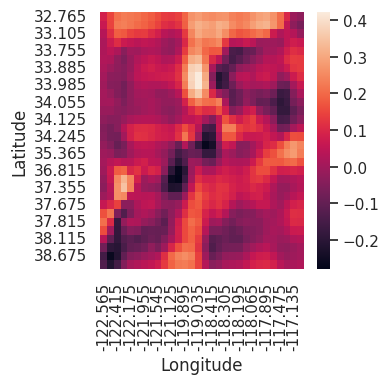

In [12]:
model.plot_pair_shape_function("Latitude", "Longitude")

The latitude/latitude interaction plot shows a few spots of lower and higher median house values. For example, the lightest spot around (34, -118.5) corresponds to Los Angeles. 

## Survival Analysis

DNAMite can be also be used for survival analysis. Briefly, survival analysis involves predicting the probability that a time-to-event variable $T$ happens before $t$ for all times $t > 0$. For more details see the [Survival Analysis User Guide](https://dnamite.readthedocs.io/en/latest/notebooks/user_guides/survival_analysis.html). 
We'll use the SUPPORT dataset [1], which we pull from the [UCI repository](https://archive.ics.uci.edu/dataset/880/support2) where more dataset details can be found.

[1] Knaus, William A., et al. "The SUPPORT prognostic model: Objective estimates of survival for seriously ill hospitalized adults." Annals of internal medicine 122.3 (1995): 191-203.

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
support2 = fetch_ucirepo(id=880) 
X = support2.data.features 
y = np.empty(X.shape[0], dtype=[("event", bool), ("time", float)])
y["event"] = support2.data.original["death"]
y["time"] = support2.data.original["d.time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Fitting a DNAMite model for survival analysis is very similar to fitting a DNAMite regression model. Importantly, the `DNAMiteSurvival` model expects labels to be NumPy structured arrays with the dype `np.dtype([('event', bool), ('time', float)])`, where `event` is True only when the samples is not censored and `time` is the event/censor time.

In [21]:
from dnamite.models import DNAMiteSurvival

model = DNAMiteSurvival(
    n_features=X_train.shape[1],
    device=device,
    num_pairs=5
)
model.fit(X_train, y_train)

To evaluate the accuracy of the model, there are several metrics we could use. We recommend using the survival AUC metrics from scikit-survival.

In [22]:
from sksurv.metrics import cumulative_dynamic_auc

test_times = np.linspace(
    max(y_train["time"].min(), y_test[y_test["event"] > 0]["time"].min()) + 1e-4,
    min(y_train["time"].max(), y_test[y_test["event"] > 0]["time"].max()) - 1e-4,
    100
)

surv_preds = model.predict_survival(X_test, test_times)
_, mean_auc = cumulative_dynamic_auc(y_train, y_test, 1 - surv_preds, test_times)
mean_auc

0.9637237744449257

As with the regression model, we can generate feature importances as well as shape functions from the model. Unique to survival analysis, these interpretations will be *time-dependent*, i.e. describing predictions of experiencing the event before time $t$ for specified time $t$.

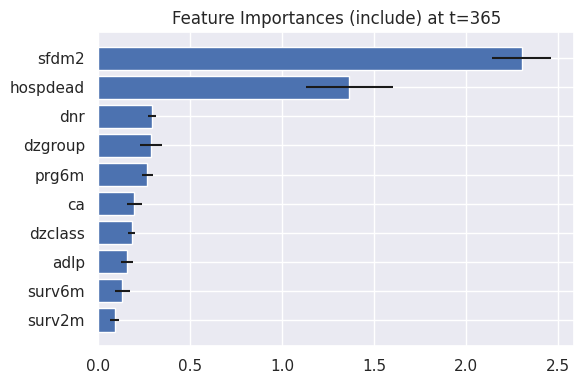

In [26]:
model.plot_feature_importances(eval_times=365)

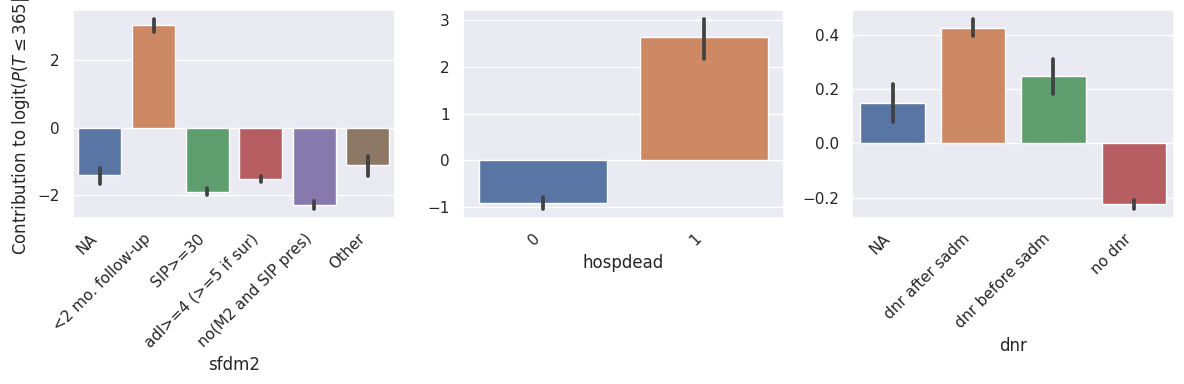

In [28]:
model.plot_shape_function(["sfdm2", "hospdead", "dnr"], eval_times=365)